In [31]:
# pip install prophet
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:


path = r"c:\Users\KDD\Downloads\JKL WS100"
df = pd.read_csv(path + r"\Data\Kotaniementie\Kotaniementie_202501-202509.csv", delimiter=";")

In [33]:
df.head(5)

,Timestamp,precipitationIntensity_mm_h,precipitationIntensity_mm_min,precipitationQuantityAbs_mm,precipitationQuantityDiff_mm,precipitationType
0,2025-01-01 00:05:16,0.0,0.0,104.69,0.0,0
1,2025-01-01 00:15:16,0.0,0.0,104.69,0.0,0
2,2025-01-01 00:25:16,0.0,0.0,104.69,0.0,0
3,2025-01-01 00:35:16,0.0,0.0,104.69,0.0,0
4,2025-01-01 00:45:17,0.0,0.0,104.69,0.0,0


In [34]:
# Prophet requires a certain naming convention
# ds => timestamp field / sequence number => has to be in DateTime-format (pandas)
# y => target variable
# support variables can be called as they are

# PROPHET REQUIRES A NAMING CONVENTION
# target is y , timestamp is ds
df = df.rename({"precipitationQuantityDiff_mm": "y", "Timestamp": "ds"}, axis=1)

# process the timestamps => force the data type into pandas DateTime-object
# and then round all values into exactly 10 minute intervals
df['ds'] = pd.to_datetime(df['ds'], format="mixed")
df['ds'] = df['ds'].dt.round("10min")

In [35]:
from sklearn.preprocessing import MinMaxScaler

# initialize scaler
scaler = MinMaxScaler()

# save the original min/max so we can convert the Prophet's output
# back to original values
# you can use inverse-transform with this as well
y_min = df['y'].min()
y_max = df['y'].max()

In [36]:
 # only take 1000 points, let's experiment on that
index_cut = 27100
df = df.iloc[index_cut:index_cut + 1200]

In [37]:
len(df)

1200

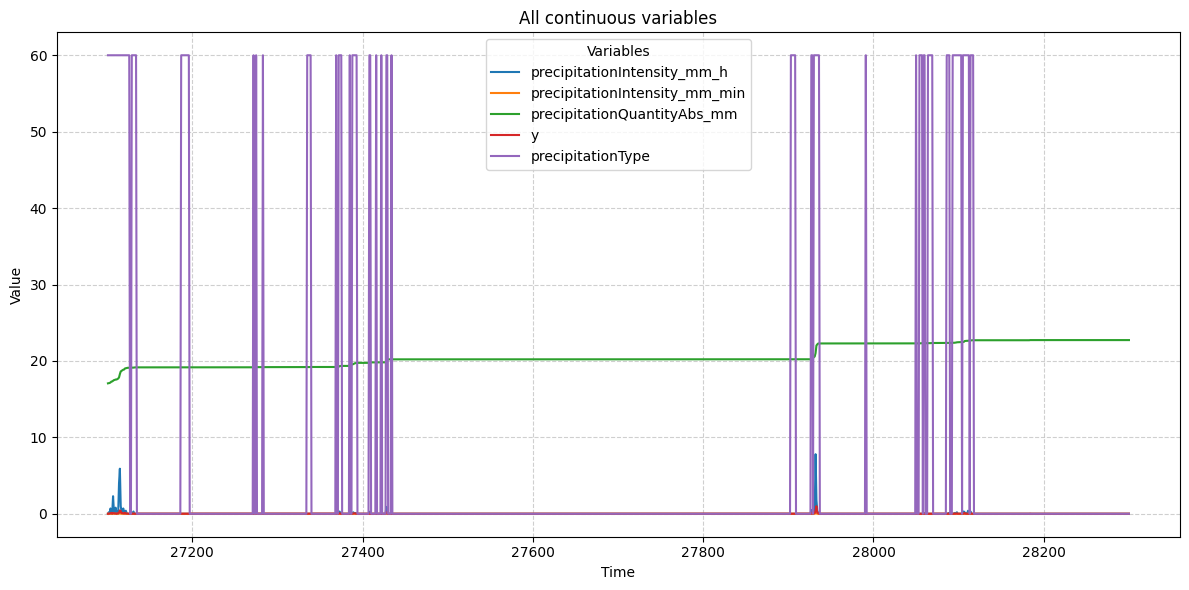

In [38]:
# plot everything we have
df_copy = df.copy()
df_copy['sequence'] = df_copy.index + 1
df_copy = df_copy.drop(['ds'], axis=1)
df_copy.set_index("sequence", inplace=True)

plt.figure(figsize=(12, 6))

for column in df_copy.columns:
    plt.plot(df_copy.index, df_copy[column], label=column)

plt.title("All continuous variables")
plt.xlabel("Time")
plt.ylabel("Value")

plt.legend(title="Variables")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [39]:
# initialize the model and add helper variables
model = Prophet(changepoint_prior_scale=0.5, scaling='minmax')


# add support variables as regressors
# model.add_regressor("Road_Surface_Temperature")
# model.add_regressor("Water_Film_Surface_mm")

# fit the model with the data
model.fit(df)

08:45:56 - cmdstanpy - INFO - Chain [1] start processing
08:45:57 - cmdstanpy - INFO - Chain [1] done processing


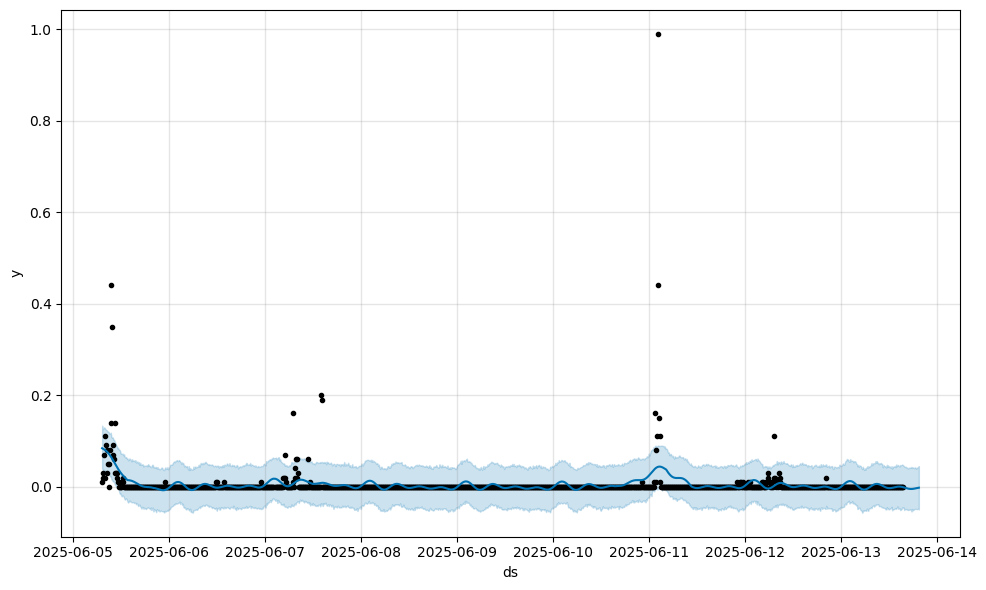

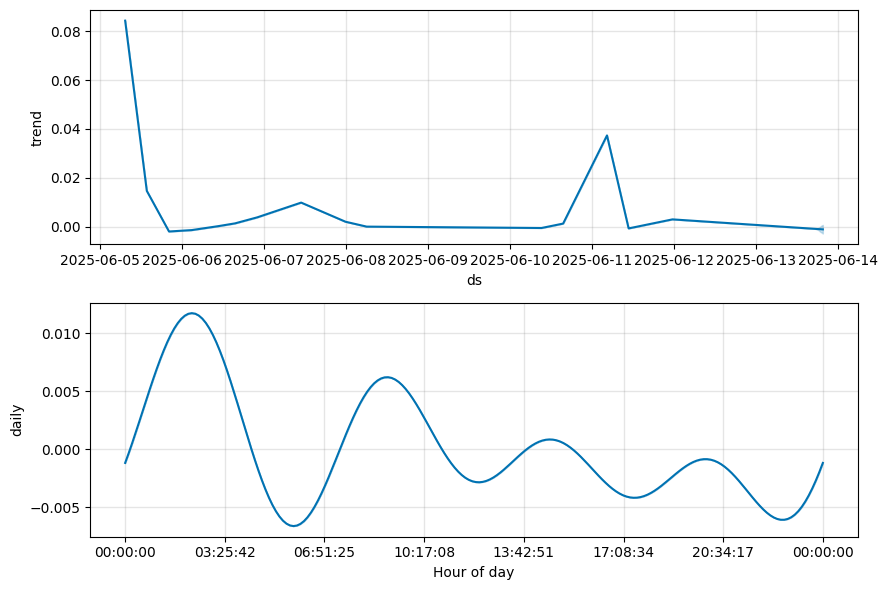

In [40]:
# initialize the future DataFrame / extrapolation
future = model.make_future_dataframe(periods=24, freq="10min")

# we have to initialize the support variables
# NOTE: this is a part where you can use multiple strategies
# that affect the way how future predictions are made
# future["Road_Surface_Temperature"] = df["Road_Surface_Temperature"].rolling(window=12).mean().iloc[-1]
# future["Water_Film_Surface_mm"] = df["Water_Film_Surface_mm"].rolling(window=12).mean().iloc[-1]

# extrapolate into the future
forecast = model.predict(future)

# invert the scaling of the target back to original
forecast["yhat_original_range"] = forecast['yhat'] * (y_max - y_min) + y_min
#forecast['yhat_original_range'] = scaler.inverse_transform(scaled_data)

# plot some details
fig_forecast = model.plot(forecast)
fig_components = model.plot_components(forecast)

***NEXT STEPS*** <br>
---Get data from the closest LHT to obtain humidity and temperature of surroundings<br>
---Merge that with the WS100 on timestamp(currently the ws100 has 10min interval, needs to downsample to hourly)<br>
---Use the temperature and humidity data as regressors to improve the model<br>
---Run separate Prophet models per location (since each station may have unique climate behavior)<br>
---Add more regressors (e.g., pressure, wind speed if available)<br>

In [41]:
# this is just some basic testing "e.g. does Prophet still work like this"

In [42]:
# how do we usually detect rain as human beings right before rain?
# cloudiness / visibility "sky gets darker"
# exception = in summer it's no so evident (surprise rain)
# can we have more variables to help decide where the rain is going

# dew point differences between stations => use that enhance the forecast

# e.g. dew point and other variables can be found in the free Digitrafic API
# https://tie.digitraffic.fi/api/weather/v1/stations/1012/data

# e.g. KASTEPISTE => DEW POINT

# use different areas to try out the model and analyze if they have any common trends

# idea: combine all sensors in nearby area and get an aggregate (average or sum) of all rain
# activities and try to detect stronger signals that way
# the current measurements have pretty weak signals

# wind data would be helpful 
# also can be found in Digitraffic (TUULI)

# Digitrafic documentation
# https://www.digitraffic.fi/en/road-traffic/#current-data-of-road-weather-stations

# we can quickly use 2023 data for this (instructor will add to Teams)

In [43]:
# some other ideas (from ChatGPT during the workshop)
# Prophet, LSTM/GRU, RNN ... XGBoost, Random Forest, CatBoost

# AI also suggests using data-driven model like Prophet + conventional forecasts as regressors
# https://medium.com/data-science/forecast-model-tuning-with-additional-regressors-in-prophet-ffcbf1777dda

In [44]:
# BASIC IMPLEMENTATION PLAN:

# Use rainfall + 1 or 2 helper variables (temperature, humidity etc.)
# experiment with Prophet + LSTM/RNN to see, which algorithm captures abrupt rains the best
# try different time periods, stations and signal lengths
# study the trend visualizations of Prophet and extrapolations from RNN/LSTM